In [191]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from environment import Environment
from actor import Actor
from copy import deepcopy
from tqdm import tqdm

In [192]:
n_samples = 500
n_locations = 5
max_demand = 10
max_capacity = 50
big_number = 10000000
n_epochs = 150

model_actor = Actor(n_locations)
optimizer = tf.keras.optimizers.legacy.Adam()

env_org = Environment(n_samples, n_locations, max_demand, max_capacity)
env_test = Environment(n_samples, n_locations, max_demand, max_capacity)

In [193]:
def make_simulation(env):
    actions_approximation = []
    actions_real = []
    for _ in range(2 * n_locations):
        logits = model_actor(env, training=True) - env.mask * big_number

        logits_max = tf.nn.softmax(logits * 1)

        action_approximation = tf.reduce_mean(
            env.locations * tf.tile(tf.expand_dims(logits_max, -1), [1, 1, 2]), axis=1
        )
        actions_approximation.append(action_approximation)

        env.update(tf.argmax(logits, 1))
        actions_real.append(env.vehicle)

    return actions_approximation, actions_real

In [194]:
def calculate_loss(actions_approximation):
    acts = tf.convert_to_tensor(actions_approximation)  # shape [n_steps x n_samples x 2]
    acts_shifted = tf.concat((tf.expand_dims(actions_approximation[-1], 0), actions_approximation[:-1]), 0)

    # distances = tf.math.sqrt(tf.reduce_sum(tf.math.square(acts_shifted - acts), -1) + 1e-12)
    distances = tf.reduce_sum(tf.math.square(acts_shifted - acts), -1)

    summed_path = tf.reduce_sum(distances, axis=0)

    loss = tf.reduce_mean(summed_path) * 10000
    
    return loss

In [195]:
grads_lst = []
losses_train = []
losses_test = []

all_actions_real = []

for _ in tqdm(range(n_epochs)):
    env_train = deepcopy(env_org)
    env_test_process = deepcopy(env_test)
    with tf.GradientTape(persistent=True) as tape:

        actions_approximation_train, actions_real_train = make_simulation(env_train)
        actions_approximation_test, actions_real_test = make_simulation(env_test_process)

        loss_train = calculate_loss(actions_approximation_train)
        loss_test = calculate_loss(actions_approximation_test)
        
        losses_train.append(loss_train)
        losses_test.append(loss_test)

    all_actions_real.append(actions_real_train)    

    grads = tape.gradient(loss_train, model_actor.trainable_variables)
    grads_and_vars = zip(grads, model_actor.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    grads_lst.append(grads)

  1%|▏         | 2/150 [00:02<03:15,  1.32s/it]


KeyboardInterrupt: 

In [183]:
tf_all_actions_real = tf.convert_to_tensor(all_actions_real)
# shape: [n_epochs x n_steps x n_samples x 2]

In [184]:
def fun(ls, n):
    return [np.mean(ls[i:i+n]) for i in range(0, len(ls) - n)]

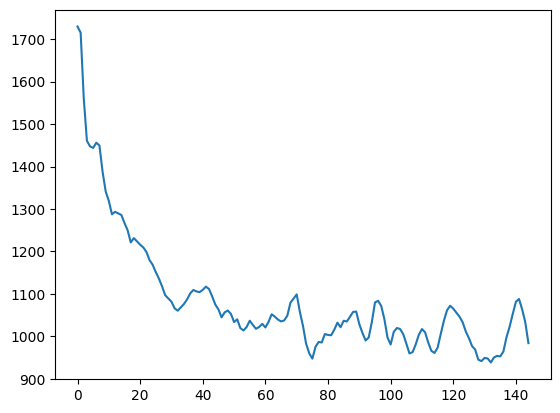

In [187]:
plt.plot(fun(losses_train, 5))
plt.show()

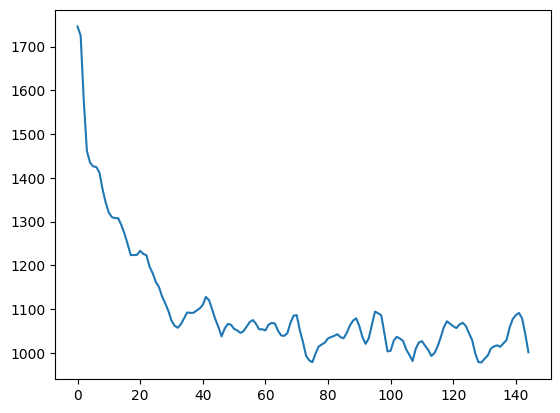

In [185]:
plt.plot(fun(losses_test, 5))
plt.show()
# plt.ylim([0, 250])

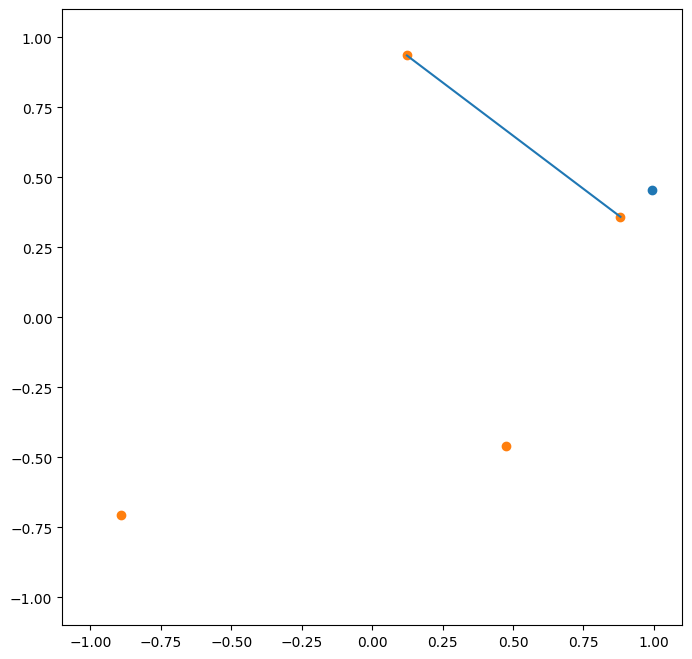

In [190]:
plt.figure(figsize=(8, 8))

sample_id = 0

plt.scatter(env_train.locations[sample_id, 0, 0], env_train.locations[sample_id, 0, 1])
plt.scatter(env_train.locations[sample_id, 1:, 0], env_train.locations[sample_id, 1:, 1])

for i in range(1):
# for i in range(n_locations * 2 - 1):
    plt.plot(
        [tf_all_actions_real[-1, i, sample_id, 0], tf_all_actions_real[-1, i + 1, sample_id, 0]],
        [tf_all_actions_real[-1, i, sample_id, 1], tf_all_actions_real[-1, i + 1, sample_id, 1]],
    )

plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.show()